In [1]:
pip install git+https://github.com/google-research/timesfm


  Cloning https://github.com/google-research/timesfm to /tmp/pip-req-build-2bck0s4t
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/timesfm /tmp/pip-req-build-2bck0s4t
  Resolved https://github.com/google-research/timesfm to commit 48779773be8aaea81bd84ee0765fc0af8b0dd23c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 9.3

In [4]:
!pip install yfinance
!pip install utilsforecast


In [5]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PMAP_USE_TENSORSTORE'] = 'false'

In [6]:
import timesfm
import gc
import numpy as np
import pandas as pd
from timesfm import patched_decoder
from timesfm import data_loader
import yfinance as yf

In [7]:
from tqdm import tqdm
import dataclasses
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [8]:
# Loading TimesFM pretrained checkpoint
tfm = timesfm.TimesFm(
    context_len=512,
    horizon_len=1,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="gpu",
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 3.76 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.87 seconds.
Jitting decoding.
Jitted decoding in 24.76 seconds.


In [53]:
import yfinance as yf
import pandas as pd
import numpy as np

# انتخاب نماد سهام (مثال: AAPL برای اپل)
ticker = 'AAPL'

# بارگذاری داده‌های بورسی روزانه
data = yf.download(ticker, start='2000-01-01', end='2023-01-01', interval='1d')
data.reset_index(inplace=True)  # تبدیل شاخص به ستون

# تغییر نام ستون‌ها
data.rename(columns={'Date': 'date', 'Close': 'y'}, inplace=True)

# انتخاب ستون‌های مناسب
ts_cols = ["Open", "High", "Low", "y", "Volume"]

# محاسبه ویژگی‌های اضافی
data['MA_10'] = data['y'].rolling(window=10).mean()
data['MA_50'] = data['y'].rolling(window=50).mean()
data['RSI'] = 100 - (100 / (1 + data['y'].pct_change().rolling(window=14).apply(lambda x: (x[x > 0].mean() / -x[x < 0].mean()) if x[x < 0].mean() != 0 else np.inf)))

# حذف مقادیر NaN
data = data.dropna()

# انتخاب ستون‌های نهایی
final_cols = ["date", "Open", "High", "Low", "y", "Volume", "MA_10", "MA_50", "RSI"]
data = data[final_cols]

# ذخیره‌سازی داده‌ها در یک فایل CSV
data_path = 'stock_data.csv'
data.to_csv(data_path, index=False)

print(f"Number of records: {len(data)}")


[*********************100%%**********************]  1 of 1 completed


Number of records: 5738


In [82]:
freq = 'D'
context_len = 32
pred_len = 1
batch_size = 14

# Define train, validation, and test boundaries
train_boundary = int(len(data) * 0.7)
val_boundary = int(len(data) * 0.85)

In [83]:
train_boundary

4016

In [59]:
data

,date,Open,High,Low,y,Volume,MA_10,MA_50,RSI
49,2000-03-14,1.082310,1.109375,1.017857,1.020089,428579200,1.102176,0.988284,57.059726
50,2000-03-15,1.032366,1.073661,1.018973,1.037946,443609600,1.089621,0.989054,52.469664
51,2000-03-16,1.047433,1.089286,1.022321,1.085379,378100800,1.089230,0.992458,53.802607
52,2000-03-17,1.072545,1.116071,1.068080,1.116071,305043200,1.086551,0.996208,53.976172
53,2000-03-20,1.102679,1.127232,1.092634,1.098214,204489600,1.084152,1.001208,58.254379
...,...,...,...,...,...,...,...,...,...
5782,2022-12-23,130.919998,132.419998,129.639999,131.860001,63814900,136.839000,144.131800,47.618672
5783,2022-12-27,131.380005,131.410004,128.720001,130.029999,69007800,135.392999,143.964799,49.449664
5784,2022-12-28,129.669998,131.029999,125.870003,126.040001,85438400,133.449999,143.637399,46.803015
5785,2022-12-29,127.989998,130.479996,127.730003,129.610001,75703700,132.089999,143.354599,52.847661


In [84]:
ts_cols = [col for col in data.columns if col != "date"]


num_ts = len(ts_cols)
# Create TimeSeriesdata loader
dtl = data_loader.TimeSeriesdata(
      data_path=data_path,
      datetime_col="date",
      num_cov_cols=None,
      cat_cov_cols=None,
      ts_cols=ts_cols,
      train_range=[0, train_boundary],
      val_range=[train_boundary, val_boundary],
      test_range=[val_boundary, len(data)],
      hist_len=context_len,
      pred_len=pred_len,
      batch_size=num_ts,  # Change as per requirement
      freq=freq,
      normalize=True,
      epoch_len=None,
      holiday=False,
      permute=True,
  )
train_batches = dtl.tf_dataset(mode="train", shift=1).batch(batch_size)
val_batches = dtl.tf_dataset(mode="val", shift=pred_len)
test_batches = dtl.tf_dataset(mode="test", shift=pred_len)

In [85]:
for tbatch in tqdm(train_batches.as_numpy_iterator()):
    pass
print(tbatch[0].shape)

569it [00:03, 181.15it/s]

(14, 8, 32)


# MAE on the test split for the pretrained TimesFM model

In [86]:
mae_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]

    actuals = batch[3]

    _, forecasts = tfm.forecast(list(past), [0] * past.shape[0])
    forecasts = forecasts[:, 0 : actuals.shape[1], 5]

    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}")

586it [00:32, 17.78it/s]


KeyboardInterrupt: 

# Fine-tuning the model

In [92]:
import jax
from jax import numpy as jnp
from praxis import pax_fiddle
from praxis import py_utils
from praxis import pytypes
from praxis import base_model
from praxis import optimizers
from praxis import schedules
from praxis import base_hyperparams
from praxis import base_layer
from paxml import tasks_lib
from paxml import trainer_lib
from paxml import checkpoints
from paxml import learners
from paxml import partitioning
from paxml import checkpoint_types

In [93]:
NestedMap = py_utils.NestedMap
WeightInit = base_layer.WeightInit
WeightHParams = base_layer.WeightHParams
InstantiableParams = py_utils.InstantiableParams
JTensor = pytypes.JTensor
NpTensor = pytypes.NpTensor
WeightedScalars = pytypes.WeightedScalars
instantiate = base_hyperparams.instantiate
LayerTpl = pax_fiddle.Config[base_layer.BaseLayer]
AuxLossStruct = base_layer.AuxLossStruct

AUX_LOSS = base_layer.AUX_LOSS
template_field = base_layer.template_field

# Standard prng key names
PARAMS = base_layer.PARAMS
RANDOM = base_layer.RANDOM

key = jax.random.PRNGKey(seed=1234)

In [94]:
model = pax_fiddle.Config(
    patched_decoder.PatchedDecoderFinetuneModel,
    name='patched_decoder_finetune',
    core_layer_tpl=tfm.model_p,
)

In [95]:

@pax_fiddle.auto_config
def build_learner() -> learners.Learner:
  return pax_fiddle.Config(
      learners.Learner,
      name='learner',
      loss_name='avg_qloss',
      optimizer=optimizers.Adam(
          epsilon=1e-7,
          clip_threshold=1e2,
          learning_rate=1e-2,
          lr_schedule=pax_fiddle.Config(
              schedules.Cosine,
              initial_value=1e-3,
              final_value=1e-4,
              total_steps=40000,
          ),
          ema_decay=0.9999,
      ),
      # Linear probing i.e we hold the transformer layers fixed.
      bprop_variable_exclusion=['.*/stacked_transformer_layer/.*'],
  )

In [96]:

task_p = tasks_lib.SingleTask(
    name='ts-learn',
    model=model,
    train=tasks_lib.SingleTask.Train(
        learner=build_learner(),
    ),
)

In [97]:
task_p.model.ici_mesh_shape = [1, 1, 1]
task_p.model.mesh_axis_names = ['replica', 'data', 'mdl']

DEVICES = np.array(jax.devices()).reshape([1, 1, 1])
MESH = jax.sharding.Mesh(DEVICES, ['replica', 'data', 'mdl'])

num_devices = jax.local_device_count()
print(f'num_devices: {num_devices}')
print(f'device kind: {jax.local_devices()[0].device_kind}')

num_devices: 1
device kind: Tesla T4


In [98]:
jax_task = task_p
key, init_key = jax.random.split(key)

# To correctly prepare a batch of data for model initialization (now that shape
# inference is merged), we take one devices*batch_size tensor tuple of data,
# slice out just one batch, then run the prepare_input_batch function over it.


def process_train_batch(batch):
    print
    past_ts = batch[0].reshape(batch_size * num_ts, -1)
    actual_ts = batch[3].reshape(batch_size * num_ts, -1)
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


def process_eval_batch(batch):
    past_ts = batch[0]
    actual_ts = batch[3]
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


jax_model_states, _ = trainer_lib.initialize_model_state(
    jax_task,
    init_key,
    process_train_batch(tbatch),
    checkpoint_type=checkpoint_types.CheckpointType.GDA,
)

In [99]:
jax_model_states.mdl_vars['params']['core_layer'] = tfm._train_state.mdl_vars['params']
jax_vars = jax_model_states.mdl_vars
gc.collect()

0

In [100]:
jax_task = task_p


def train_step(states, prng_key, inputs):
  return trainer_lib.train_step_single_learner(
      jax_task, states, prng_key, inputs
  )


def eval_step(states, prng_key, inputs):
  states = states.to_eval_state()
  return trainer_lib.eval_step_single_learner(
      jax_task, states, prng_key, inputs
  )

key, train_key, eval_key = jax.random.split(key, 3)
train_prng_seed = jax.random.split(train_key, num=jax.local_device_count())
eval_prng_seed = jax.random.split(eval_key, num=jax.local_device_count())

p_train_step = jax.pmap(train_step, axis_name='batch')
p_eval_step = jax.pmap(eval_step, axis_name='batch')

In [101]:
replicated_jax_states = trainer_lib.replicate_model_state(jax_model_states)
replicated_jax_vars = replicated_jax_states.mdl_vars

In [102]:
best_eval_loss = 1e7
step_count = 0
patience = 0
NUM_EPOCHS = 100
PATIENCE = 5
TRAIN_STEPS_PER_EVAL = 1000
CHECKPOINT_DIR='/content'

In [103]:
def reshape_batch_for_pmap(batch, num_devices):
  def _reshape(input_tensor):
    bsize = input_tensor.shape[0]
    residual_shape = list(input_tensor.shape[1:])
    nbsize = bsize // num_devices
    return jnp.reshape(input_tensor, [num_devices, nbsize] + residual_shape)

  return jax.tree.map(_reshape, batch)

In [104]:
for epoch in range(NUM_EPOCHS):
    print(f"__________________Epoch: {epoch}__________________", flush=True)
    train_its = train_batches.as_numpy_iterator()
    if patience >= PATIENCE:
        print("Early stopping.", flush=True)
        break
    for batch in tqdm(train_its):
        train_losses = []
        if patience >= PATIENCE:
            print("Early stopping.", flush=True)
            break
        tbatch = process_train_batch(batch)
        tbatch = reshape_batch_for_pmap(tbatch, num_devices)
        replicated_jax_states, step_fun_out = p_train_step(
            replicated_jax_states, train_prng_seed, tbatch
        )
        train_losses.append(step_fun_out.loss[0])
        if step_count % TRAIN_STEPS_PER_EVAL == 0:
            print(
                f"Train loss at step {step_count}: {np.mean(train_losses)}",
                flush=True,
            )
            train_losses = []
            print("Starting eval.", flush=True)
            val_its = val_batches.as_numpy_iterator()
            eval_losses = []
            for ev_batch in tqdm(val_its):
                ebatch = process_eval_batch(ev_batch)
                ebatch = reshape_batch_for_pmap(ebatch, num_devices)
                _, step_fun_out = p_eval_step(
                    replicated_jax_states, eval_prng_seed, ebatch
                )
                eval_losses.append(step_fun_out.loss[0])
            mean_loss = np.mean(eval_losses)
            print(f"Eval loss at step {step_count}: {mean_loss}", flush=True)
            if mean_loss < best_eval_loss or np.isnan(mean_loss):
                best_eval_loss = mean_loss
                print("Saving checkpoint.")
                jax_state_for_saving = py_utils.maybe_unreplicate_for_fully_replicated(
                    replicated_jax_states
                )
                checkpoints.save_checkpoint(
                    jax_state_for_saving, CHECKPOINT_DIR, overwrite=True
                )
                patience = 0
                del jax_state_for_saving
                gc.collect()
            else:
                patience += 1
                print(f"patience: {patience}")
        step_count += 1

__________________Epoch: 0__________________


0it [00:00, ?it/s]

Train loss at step 0: 0.4202340543270111
Starting eval.



0it [00:00, ?it/s]
1it [00:12, 12.71s/it]
12it [00:12,  1.30it/s]
23it [00:12,  2.99it/s]
33it [00:13,  5.10it/s]
45it [00:13,  8.55it/s]
57it [00:13, 13.11it/s]
69it [00:13, 18.98it/s]
81it [00:13, 26.27it/s]
93it [00:13, 34.94it/s]
105it [00:13, 44.69it/s]
117it [00:13, 55.07it/s]
129it [00:13, 65.45it/s]
141it [00:13, 74.90it/s]
153it [00:14, 83.27it/s]
165it [00:14, 90.58it/s]
177it [00:14, 96.36it/s]
189it [00:14, 101.13it/s]
201it [00:14, 104.56it/s]
213it [00:14, 107.15it/s]
225it [00:14, 109.00it/s]
237it [00:14, 110.39it/s]
249it [00:14, 111.03it/s]
261it [00:15, 111.42it/s]
273it [00:15, 111.81it/s]
285it [00:15, 112.30it/s]
297it [00:15, 112.68it/s]
309it [00:15, 112.92it/s]
321it [00:15, 113.00it/s]
333it [00:15, 113.24it/s]
345it [00:15, 113.32it/s]
357it [00:15, 113.23it/s]
369it [00:16, 112.95it/s]
381it [00:16, 112.88it/s]
393it [00:16, 112.50it/s]
405it [00:16, 112.18it/s]
417it [00:16, 113.37it/s]
429it [00:16, 109.26it/s]
441it [00:16, 110.43it/s]
454it [00:16, 113.

Eval loss at step 0: 0.6228346228599548


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


569it [01:33,  6.07it/s]

__________________Epoch: 1__________________



431it [00:23, 19.32it/s]

Train loss at step 1000: 0.7098879218101501
Starting eval.



0it [00:00, ?it/s]
12it [00:00, 118.74it/s]
24it [00:00, 110.41it/s]
36it [00:00, 113.71it/s]
48it [00:00, 112.73it/s]
60it [00:00, 112.33it/s]
72it [00:00, 112.06it/s]
84it [00:00, 111.72it/s]
96it [00:00, 111.52it/s]
108it [00:00, 110.50it/s]
120it [00:01, 110.28it/s]
132it [00:01, 110.37it/s]
144it [00:01, 110.70it/s]
156it [00:01, 110.89it/s]
168it [00:01, 111.02it/s]
180it [00:01, 110.92it/s]
192it [00:01, 110.97it/s]
204it [00:01, 110.98it/s]
216it [00:01, 110.59it/s]
228it [00:02, 110.40it/s]
240it [00:02, 110.38it/s]
252it [00:02, 110.54it/s]
264it [00:02, 110.75it/s]
276it [00:02, 110.78it/s]
288it [00:02, 110.84it/s]
300it [00:02, 110.89it/s]
312it [00:02, 110.90it/s]
324it [00:02, 110.69it/s]
336it [00:03, 110.54it/s]
348it [00:03, 110.46it/s]
360it [00:03, 110.54it/s]
372it [00:03, 110.63it/s]
384it [00:03, 110.66it/s]
396it [00:03, 110.75it/s]
408it [00:03, 110.81it/s]
420it [00:03, 110.79it/s]
432it [00:03, 110.72it/s]
444it [00:04, 110.57it/s]
456it [00:04, 110.48it/s]


Eval loss at step 1000: 0.581082284450531


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


569it [00:56, 10.05it/s]

__________________Epoch: 2__________________



569it [00:32, 17.60it/s]

__________________Epoch: 3__________________



293it [00:16, 18.25it/s]

Train loss at step 2000: 0.64112788438797
Starting eval.



0it [00:00, ?it/s]
13it [00:00, 120.07it/s]
26it [00:00, 113.55it/s]
38it [00:00, 111.54it/s]
50it [00:00, 110.67it/s]
62it [00:00, 110.09it/s]
74it [00:00, 109.73it/s]
85it [00:00, 109.51it/s]
96it [00:00, 109.15it/s]
107it [00:00, 107.41it/s]
118it [00:01, 107.55it/s]
129it [00:01, 107.71it/s]
140it [00:01, 108.32it/s]
151it [00:01, 108.58it/s]
162it [00:01, 108.85it/s]
173it [00:01, 108.96it/s]
184it [00:01, 108.71it/s]
195it [00:01, 108.69it/s]
206it [00:01, 108.01it/s]
217it [00:01, 107.81it/s]
228it [00:02, 108.13it/s]
239it [00:02, 108.26it/s]
250it [00:02, 108.61it/s]
261it [00:02, 108.83it/s]
272it [00:02, 108.86it/s]
283it [00:02, 108.96it/s]
294it [00:02, 108.37it/s]
305it [00:02, 105.43it/s]
316it [00:02, 103.08it/s]
327it [00:03, 102.96it/s]
339it [00:03, 106.66it/s]
351it [00:03, 107.06it/s]
362it [00:03, 107.60it/s]
374it [00:03, 108.81it/s]
385it [00:03, 108.98it/s]
396it [00:03, 109.08it/s]
407it [00:03, 106.38it/s]
419it [00:03, 109.23it/s]
430it [00:03, 108.84it/s]


Eval loss at step 2000: 0.5757408142089844


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


569it [01:07,  8.43it/s]

__________________Epoch: 4__________________



569it [00:33, 17.12it/s]

__________________Epoch: 5__________________



154it [00:08, 18.65it/s]

Train loss at step 3000: 0.6074879169464111
Starting eval.



0it [00:00, ?it/s]
12it [00:00, 118.11it/s]
24it [00:00, 113.23it/s]
36it [00:00, 111.64it/s]
48it [00:00, 111.03it/s]
60it [00:00, 110.72it/s]
72it [00:00, 110.40it/s]
84it [00:00, 110.29it/s]
96it [00:00, 110.10it/s]
108it [00:00, 108.75it/s]
119it [00:01, 108.68it/s]
130it [00:01, 109.04it/s]
142it [00:01, 109.34it/s]
154it [00:01, 109.56it/s]
165it [00:01, 109.68it/s]
177it [00:01, 109.81it/s]
189it [00:01, 109.87it/s]
200it [00:01, 109.83it/s]
211it [00:01, 109.37it/s]
222it [00:02, 108.96it/s]
233it [00:02, 108.79it/s]
245it [00:02, 109.22it/s]
257it [00:02, 109.42it/s]
269it [00:02, 109.64it/s]
281it [00:02, 109.76it/s]
293it [00:02, 109.86it/s]
304it [00:02, 109.86it/s]
315it [00:02, 109.41it/s]
326it [00:02, 109.04it/s]
337it [00:03, 109.18it/s]
348it [00:03, 109.22it/s]
360it [00:03, 109.46it/s]
371it [00:03, 109.61it/s]
383it [00:03, 109.80it/s]
395it [00:03, 109.93it/s]
406it [00:03, 109.88it/s]
417it [00:03, 109.64it/s]
428it [00:03, 109.39it/s]
439it [00:04, 109.36it/s]


Eval loss at step 3000: 0.5848981142044067


159it [00:17,  1.25it/s]

patience: 1


569it [00:40, 14.16it/s]

__________________Epoch: 6__________________



569it [00:32, 17.61it/s]

__________________Epoch: 7__________________



16it [00:00, 18.62it/s]

Train loss at step 4000: 0.6519331336021423
Starting eval.



0it [00:00, ?it/s]
12it [00:00, 114.07it/s]
24it [00:00, 111.41it/s]
36it [00:00, 110.53it/s]
48it [00:00, 110.19it/s]
60it [00:00, 109.90it/s]
71it [00:00, 109.78it/s]
82it [00:00, 109.69it/s]
93it [00:00, 109.50it/s]
104it [00:00, 107.92it/s]
115it [00:01, 107.49it/s]
126it [00:01, 107.96it/s]
137it [00:01, 108.00it/s]
149it [00:01, 108.84it/s]
160it [00:01, 109.04it/s]
171it [00:01, 109.12it/s]
182it [00:01, 109.34it/s]
193it [00:01, 109.32it/s]
204it [00:01, 108.89it/s]
215it [00:01, 108.06it/s]
226it [00:02, 108.04it/s]
237it [00:02, 108.12it/s]
248it [00:02, 108.46it/s]
259it [00:02, 108.77it/s]
270it [00:02, 109.05it/s]
281it [00:02, 109.16it/s]
292it [00:02, 109.30it/s]
303it [00:02, 109.30it/s]
314it [00:02, 108.94it/s]
325it [00:02, 108.44it/s]
336it [00:03, 108.33it/s]
347it [00:03, 108.32it/s]
358it [00:03, 108.50it/s]
369it [00:03, 106.48it/s]
381it [00:03, 109.72it/s]
392it [00:03, 109.62it/s]
403it [00:03, 109.51it/s]
414it [00:03, 109.18it/s]
425it [00:03, 108.92it/s]


Eval loss at step 4000: 0.5864497423171997


21it [00:09,  1.23it/s]

patience: 2


569it [00:40, 14.16it/s]

__________________Epoch: 8__________________



448it [00:25, 18.79it/s]

Train loss at step 5000: 0.49536728858947754
Starting eval.



0it [00:00, ?it/s]
12it [00:00, 117.86it/s]
24it [00:00, 112.70it/s]
36it [00:00, 111.35it/s]
48it [00:00, 110.90it/s]
60it [00:00, 110.55it/s]
72it [00:00, 110.31it/s]
84it [00:00, 110.24it/s]
96it [00:00, 110.07it/s]
108it [00:00, 108.14it/s]
119it [00:01, 108.31it/s]
130it [00:01, 108.74it/s]
141it [00:01, 108.91it/s]
153it [00:01, 109.30it/s]
165it [00:01, 109.51it/s]
176it [00:01, 109.58it/s]
188it [00:01, 109.71it/s]
199it [00:01, 109.65it/s]
210it [00:01, 109.06it/s]
221it [00:02, 108.61it/s]
232it [00:02, 108.67it/s]
243it [00:02, 109.01it/s]
254it [00:02, 109.18it/s]
265it [00:02, 109.30it/s]
277it [00:02, 109.54it/s]
288it [00:02, 109.65it/s]
299it [00:02, 109.63it/s]
310it [00:02, 109.37it/s]
321it [00:02, 109.00it/s]
332it [00:03, 108.82it/s]
343it [00:03, 108.91it/s]
354it [00:03, 109.11it/s]
365it [00:03, 109.20it/s]
376it [00:03, 109.40it/s]
388it [00:03, 109.66it/s]
399it [00:03, 109.64it/s]
410it [00:03, 109.37it/s]
421it [00:03, 109.29it/s]
432it [00:03, 109.06it/s]


Eval loss at step 5000: 0.5788224935531616


453it [00:33,  1.28it/s]

patience: 3


569it [00:40, 13.97it/s]

__________________Epoch: 9__________________



569it [00:32, 17.71it/s]

__________________Epoch: 10__________________



309it [00:17, 18.91it/s]

Train loss at step 6000: 0.9555670022964478
Starting eval.



0it [00:00, ?it/s]
12it [00:00, 111.14it/s]
24it [00:00, 110.38it/s]
36it [00:00, 110.13it/s]
48it [00:00, 110.04it/s]
60it [00:00, 110.03it/s]
72it [00:00, 109.93it/s]
83it [00:00, 109.93it/s]
94it [00:00, 109.95it/s]
105it [00:00, 108.01it/s]
116it [00:01, 107.81it/s]
127it [00:01, 108.11it/s]
139it [00:01, 108.80it/s]
151it [00:01, 109.24it/s]
162it [00:01, 109.41it/s]
173it [00:01, 109.45it/s]
185it [00:01, 109.68it/s]
197it [00:01, 109.76it/s]
208it [00:01, 109.21it/s]
219it [00:02, 108.70it/s]
230it [00:02, 108.66it/s]
241it [00:02, 108.94it/s]
252it [00:02, 109.15it/s]
264it [00:02, 109.43it/s]
275it [00:02, 109.55it/s]
286it [00:02, 109.56it/s]
298it [00:02, 109.74it/s]
309it [00:02, 109.42it/s]
320it [00:02, 109.03it/s]
331it [00:03, 108.83it/s]
342it [00:03, 108.85it/s]
353it [00:03, 108.96it/s]
364it [00:03, 109.20it/s]
376it [00:03, 109.48it/s]
387it [00:03, 109.59it/s]
398it [00:03, 109.56it/s]
409it [00:03, 109.57it/s]
420it [00:03, 109.30it/s]
431it [00:03, 109.05it/s]


Eval loss at step 6000: 0.5786038041114807


314it [00:25,  1.25it/s]

patience: 4


569it [00:40, 14.04it/s]

__________________Epoch: 11__________________



569it [00:32, 17.62it/s]

__________________Epoch: 12__________________



172it [00:09, 17.79it/s]

Train loss at step 7000: 0.789203405380249
Starting eval.



0it [00:00, ?it/s]
13it [00:00, 118.97it/s]
25it [00:00, 110.12it/s]
37it [00:00, 110.10it/s]
49it [00:00, 109.96it/s]
61it [00:00, 109.82it/s]
72it [00:00, 109.79it/s]
83it [00:00, 109.71it/s]
94it [00:00, 109.72it/s]
105it [00:00, 108.70it/s]
116it [00:01, 108.39it/s]
127it [00:01, 108.41it/s]
139it [00:01, 108.95it/s]
150it [00:01, 109.17it/s]
161it [00:01, 109.36it/s]
172it [00:01, 109.38it/s]
184it [00:01, 109.58it/s]
195it [00:01, 109.62it/s]
206it [00:01, 109.22it/s]
217it [00:01, 108.76it/s]
228it [00:02, 108.47it/s]
239it [00:02, 108.50it/s]
250it [00:02, 108.91it/s]
261it [00:02, 109.16it/s]
272it [00:02, 109.33it/s]
283it [00:02, 109.38it/s]
294it [00:02, 109.49it/s]
305it [00:02, 109.46it/s]
316it [00:02, 109.18it/s]
327it [00:02, 108.81it/s]
338it [00:03, 108.67it/s]
349it [00:03, 108.61it/s]
360it [00:03, 108.89it/s]
371it [00:03, 109.14it/s]
382it [00:03, 109.29it/s]
393it [00:03, 109.35it/s]
404it [00:03, 109.44it/s]
415it [00:03, 109.28it/s]
426it [00:03, 108.98it/s]


Eval loss at step 7000: 0.5814095139503479
patience: 5
Early stopping.


173it [00:18,  9.57it/s]

__________________Epoch: 13__________________
Early stopping.


In [105]:
train_state = checkpoints.restore_checkpoint(jax_model_states, CHECKPOINT_DIR)
print(train_state.step)
tfm._train_state.mdl_vars['params'] = train_state.mdl_vars['params']['core_layer']
tfm.jit_decode()

ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


2001
Jitting decoding.
Jitted decoding in 22.13 seconds.


In [106]:
mae_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]
    actuals = batch[3]
    _, forecasts = tfm.forecast(list(past), [0] * past.shape[0])
    forecasts = forecasts[:, 0 : actuals.shape[1], 5]
    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}")

861it [00:52, 16.45it/s]


MAE: 0.1553880125284195


In [107]:
ticker = 'AAPL'
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
data.reset_index(inplace=True)
data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
data['unique_id'] = 'AAPL'
data.columns

[*********************100%%**********************]  1 of 1 completed


Index(['ds', 'Open', 'High', 'Low', 'y', 'Adj Close', 'Volume', 'unique_id'], dtype='object')

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [111]:

# تابع پیش‌بینی برای روز بعد
def predict_next_day(train_data):
    forecast_df = tfm.forecast_on_df(
        inputs=train_data,
        freq="D",
        value_name="y",
        num_jobs=-1,
    )
    print('forecast_df.iloc[-1]',forecast_df)
    return {
        'timesfm': forecast_df.iloc[-1]['timesfm'],
        'timesfm-q-0.1': forecast_df.iloc[-1]['timesfm-q-0.1'],
        'timesfm-q-0.2': forecast_df.iloc[-1]['timesfm-q-0.2'],
        'timesfm-q-0.3': forecast_df.iloc[-1]['timesfm-q-0.3'],
        'timesfm-q-0.4': forecast_df.iloc[-1]['timesfm-q-0.4'],
        'timesfm-q-0.5': forecast_df.iloc[-1]['timesfm-q-0.5'],
        'timesfm-q-0.6': forecast_df.iloc[-1]['timesfm-q-0.6'],
        'timesfm-q-0.7': forecast_df.iloc[-1]['timesfm-q-0.7'],
        'timesfm-q-0.8': forecast_df.iloc[-1]['timesfm-q-0.8'],
        'timesfm-q-0.9': forecast_df.iloc[-1]['timesfm-q-0.9'],
    }

# تقسیم داده‌ها به پنجره‌های زمانی و پیش‌بینی
window_size = 30
results = []

date_range = pd.date_range(start=start_date, end=end_date)

for i in range(len(date_range) - window_size):
    train_window_start = date_range[i]
    train_window_end = date_range[i + window_size - 1]
    predict_date = date_range[i + window_size]
    print('train_window_start',train_window_start,'train_window_end',train_window_end,'predict_date',predict_date)

    train_data = data[(data['ds'] >= train_window_start) & (data['ds'] <= train_window_end)]
    print('train_data',train_data)
    print('train_data_shape',train_data.shape)
    if predict_date not in data['ds'].values:
        print(f"Skipping prediction for {predict_date} as it's not in the data.")
        continue

    actual_value = data[data['ds'] == predict_date]['y'].values
    predicted_values = predict_next_day(train_data)

    result = {
        'ds': predict_date,
        'y_actual': actual_value[0],
        'y_predicted': predicted_values['timesfm'],
        'timesfm-q-0.1': predicted_values['timesfm-q-0.1'],
        'timesfm-q-0.2': predicted_values['timesfm-q-0.2'],
        'timesfm-q-0.3': predicted_values['timesfm-q-0.3'],
        'timesfm-q-0.4': predicted_values['timesfm-q-0.4'],
        'timesfm-q-0.5': predicted_values['timesfm-q-0.5'],
        'timesfm-q-0.6': predicted_values['timesfm-q-0.6'],
        'timesfm-q-0.7': predicted_values['timesfm-q-0.7'],
        'timesfm-q-0.8': predicted_values['timesfm-q-0.8'],
        'timesfm-q-0.9': predicted_values['timesfm-q-0.9'],
    }

    results.append(result)



Streaming output truncated to the last 5000 lines.
train_data_shape (20, 8)
Skipping prediction for 2023-10-01 00:00:00 as it's not in the data.
train_window_start 2023-09-02 00:00:00 train_window_end 2023-10-01 00:00:00 predict_date 2023-10-02 00:00:00
train_data             ds        Open        High         Low           y   Adj Close  \
168 2023-09-05  188.279999  189.979996  187.610001  189.699997  188.952682   
169 2023-09-06  188.399994  188.850006  181.470001  182.910004  182.189438   
170 2023-09-07  175.179993  178.210007  173.539993  177.559998  176.860504   
171 2023-09-08  178.350006  180.240005  177.789993  178.179993  177.478058   
172 2023-09-11  180.070007  180.300003  177.339996  179.360001  178.653412   
173 2023-09-12  179.490005  180.130005  174.820007  176.300003  175.605484   
174 2023-09-13  176.509995  177.300003  173.979996  174.210007  173.523712   
175 2023-09-14  174.000000  176.100006  173.580002  175.740005  175.047684   
176 2023-09-15  176.479996  176.5

In [112]:
import pandas as pd

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save DataFrame to CSV file
results_df.to_csv('fine_tune.csv', index=False)

print("Results saved to prediction_results.csv")
# Create a DataFrame from results
results_df = pd.DataFrame(results)


Results saved to prediction_results.csv


In [ ]:
results_df=pd.read_csv('/content/merged_file.csv',)
results_df

MSE for the predictive model: 5.654298784583203
MSE for the naive prediction: 4.608868222595597


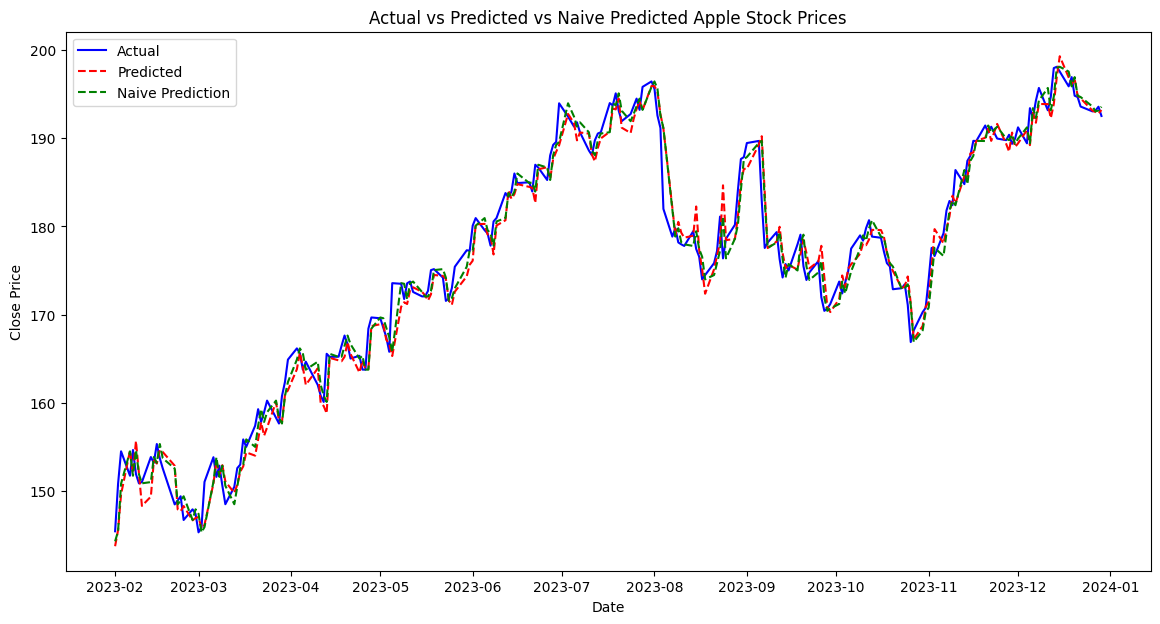

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


mse_model = mean_squared_error(results_df['y_actual'], results_df['y_predicted'])
print(f'MSE for the predictive model: {mse_model}')

# محاسبه MSE برای پیش‌بینی ناهموار (فرض می‌کنیم قیمت فردا برابر با قیمت امروز است)
results_df['y_naive'] = results_df['y_actual'].shift(1)  # قیمت ناهموار
results_df.dropna(inplace=True)


mse_naive = mean_squared_error(results_df['y_actual'], results_df['y_naive'])
print(f'MSE for the naive prediction: {mse_naive}')

# رسم نمودار مقایسه‌ای
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['y_actual'], label='Actual', color='blue')
plt.plot(results_df['ds'], results_df['y_predicted'], label='Predicted', color='red', linestyle='--')
plt.plot(results_df['ds'], results_df['y_naive'], label='Naive Prediction', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted vs Naive Predicted Apple Stock Prices')
plt.legend()
plt.show()


In [114]:
import pandas as pd



# Initialize variables for accuracy calculation
correct_predictions = 0
total_predictions = 0

# Iterate through each row in the DataFrame
for i in range(1, len(results_df)):
    # Get actual and predicted prices for the current and previous days
    actual_today = results_df.iloc[i]['y_actual']
    predicted_today = results_df.iloc[i]['y_predicted']
    actual_yesterday_index = i - 1
    actual_yesterday_date = results_df.iloc[actual_yesterday_index]['ds']

    # Check if the date of the previous row is the previous day of the current row
    if pd.to_datetime(actual_yesterday_date) != pd.to_datetime(results_df.iloc[i]['ds']) - pd.DateOffset(days=1):
        continue  # Skip this row if the previous date is not the previous day

    actual_yesterday = results_df.iloc[actual_yesterday_index]['y_actual']

    # Calculate actual and predicted movements
    actual_movement = actual_today - actual_yesterday
    predicted_movement = predicted_today - actual_yesterday  # We use yesterday's actual price as reference

    # Check if the directions of actual and predicted movements match
    if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
        correct_predictions += 1

    total_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Accuracy based on price movements:", accuracy)


Accuracy based on price movements: 0.49444444444444446


In [115]:
results_df

,ds,y_actual,y_predicted,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,y_naive
1,2023-02-01,145.429993,143.735489,138.038666,140.502045,141.913528,142.765167,143.735489,144.062759,144.759430,145.578537,147.175552,144.289993
2,2023-02-02,150.820007,145.565598,141.945480,143.604324,144.452957,144.995010,145.565598,145.937988,146.541962,147.169083,148.494370,145.429993
3,2023-02-03,154.500000,149.615036,145.330093,147.154266,148.373993,148.963516,149.615036,150.044922,150.771378,151.460968,152.917404,150.820007
4,2023-02-06,151.729996,154.580261,148.956085,151.569656,153.221115,153.951492,154.580261,154.924561,155.800079,156.744003,158.272141,154.500000
5,2023-02-07,154.649994,152.024307,147.121735,149.364548,150.790573,151.278183,152.024307,152.225052,153.027847,153.673477,155.078934,151.729996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,2023-12-22,193.600006,194.531876,192.302353,193.064285,193.650299,194.084869,194.531876,194.853592,195.243088,195.786362,196.659393,194.679993
227,2023-12-26,193.050003,193.129715,190.960663,191.694519,192.243835,192.645767,193.129715,193.469040,193.905777,194.445282,195.344574,193.600006
228,2023-12-27,193.149994,192.976929,191.038620,191.716721,192.205276,192.572586,192.976929,193.284805,193.630600,194.069809,194.862961,193.050003
229,2023-12-28,193.580002,192.819061,191.096954,191.671570,192.132721,192.470490,192.819061,193.053040,193.337265,193.746857,194.469559,193.149994


Total Profit: 19.87 USD
            ds    y_actual  y_predicted signal  buy_sell_all_capital
1   2023-02-01  145.429993   143.735489    Buy            100.000000
2   2023-02-02  150.820007   145.565598    Buy            103.706261
3   2023-02-03  154.500000   149.615036    Buy            106.236683
4   2023-02-06  151.729996   154.580261   Sell            104.331983
5   2023-02-07  154.649994   152.024307    Buy            104.331983
..         ...         ...          ...    ...                   ...
226 2023-12-22  193.600006   194.531876   Sell            120.519550
227 2023-12-26  193.050003   193.129715   Sell            120.519550
228 2023-12-27  193.149994   192.976929   Sell            120.519550
229 2023-12-28  193.580002   192.819061    Buy            120.519550
230 2023-12-29  192.529999   193.203537   Sell            119.865837

[230 rows x 5 columns]


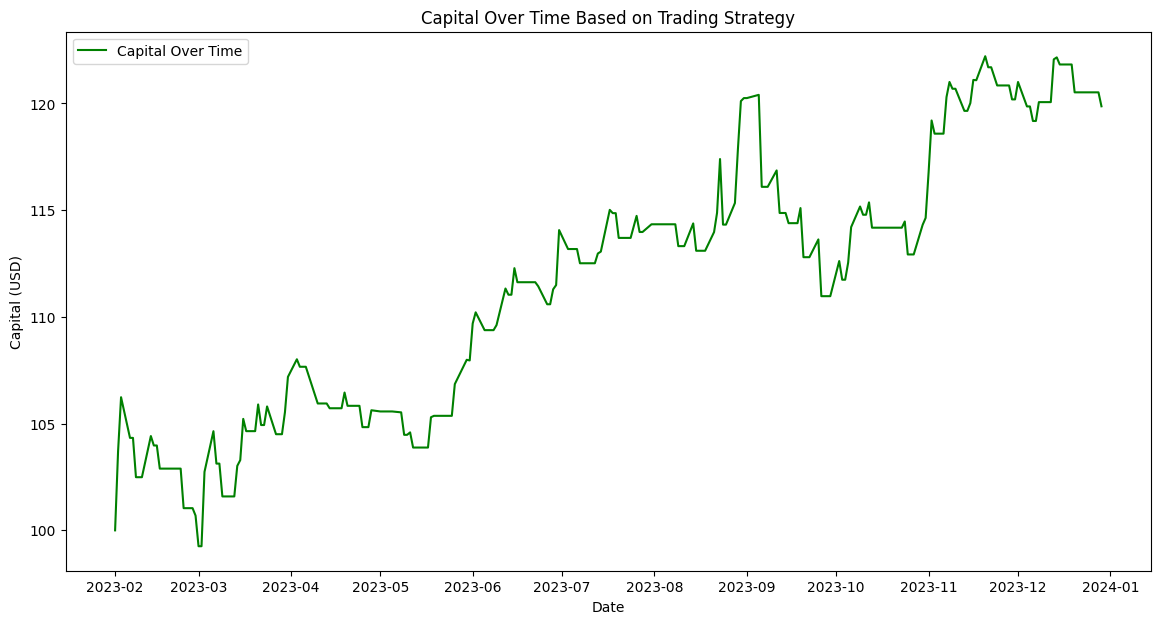

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []
# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با تمام سرمایه
        shares = capital / results_df.loc[i, 'y_actual']

        capital = 0  # تمام سرمایه به سهام تبدیل می‌شود
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        # فروش تمام سهام و تبدیل به پول نقد
        capital = shares * results_df.loc[i, 'y_actual']
        shares = 0  # تمام سهام فروخته می‌شود
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['buy_sell_all_capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'buy_sell_all_capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['buy_sell_all_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


Total Profit: 19.88 USD
            ds    y_actual  y_predicted signal  naive_capital
1   2023-02-01  145.429993   143.735489    Buy     100.000000
2   2023-02-02  150.820007   145.565598    Buy     103.706261
3   2023-02-03  154.500000   149.615036    Buy     106.236683
4   2023-02-06  151.729996   154.580261   Sell     104.331983
5   2023-02-07  154.649994   152.024307    Buy     104.331983
..         ...         ...          ...    ...            ...
226 2023-12-22  193.600006   194.531876   Sell     120.265331
227 2023-12-26  193.050003   193.129715   Sell     120.265331
228 2023-12-27  193.149994   192.976929    Buy     120.265331
229 2023-12-28  193.580002   192.819061    Buy     120.533076
230 2023-12-29  192.529999   193.203537   Sell     119.879289

[230 rows x 5 columns]


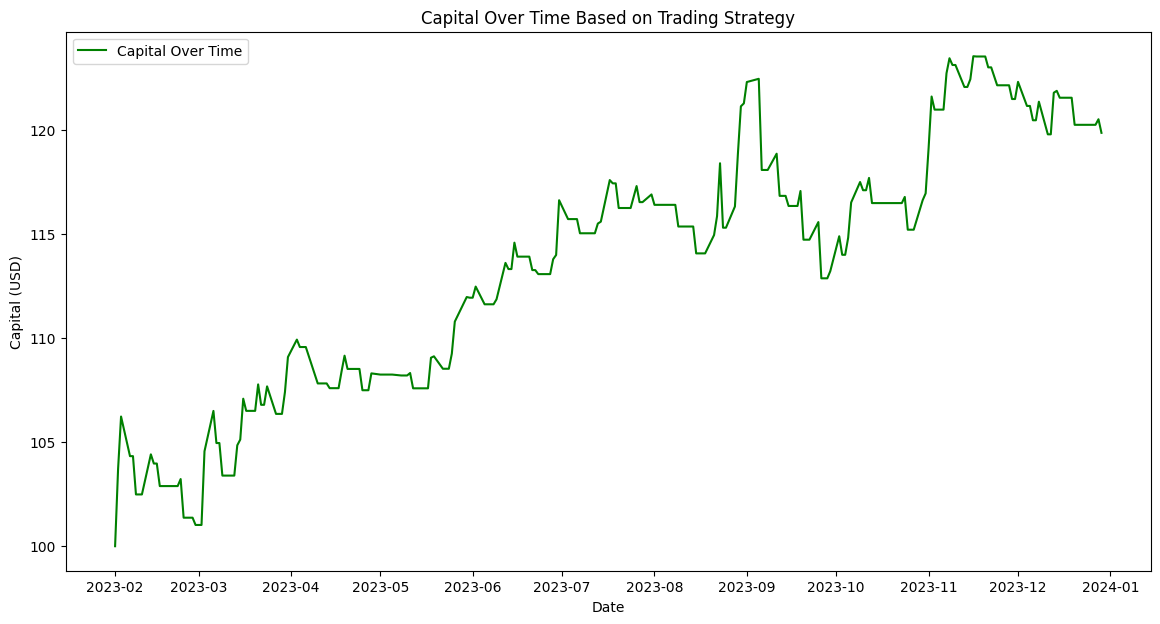

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_naive'].shift(-1) > results_df['y_naive'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []


# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با تمام سرمایه
        shares = capital / results_df.loc[i, 'y_actual']

        capital = 0  # تمام سرمایه به سهام تبدیل می‌شود
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        # فروش تمام سهام و تبدیل به پول نقد
        capital = shares * results_df.loc[i, 'y_actual']
        shares = 0  # تمام سهام فروخته می‌شود
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['naive_capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'naive_capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['naive_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


Total Profit: 10.63 USD
            ds    y_actual  y_predicted signal  buy_fraction_sell_all_capital
1   2023-02-01  145.429993   143.735489    Buy                     100.000000
2   2023-02-02  150.820007   145.565598    Buy                     101.853130
3   2023-02-03  154.500000   149.615036    Buy                     103.728339
4   2023-02-06  151.729996   154.580261   Sell                     102.092721
5   2023-02-07  154.649994   152.024307    Buy                     102.092721
..         ...         ...          ...    ...                            ...
226 2023-12-22  193.600006   194.531876   Sell                     110.933777
227 2023-12-26  193.050003   193.129715   Sell                     110.933777
228 2023-12-27  193.149994   192.976929   Sell                     110.933777
229 2023-12-28  193.580002   192.819061    Buy                     110.933777
230 2023-12-29  192.529999   193.203537   Sell                     110.632918

[230 rows x 5 columns]


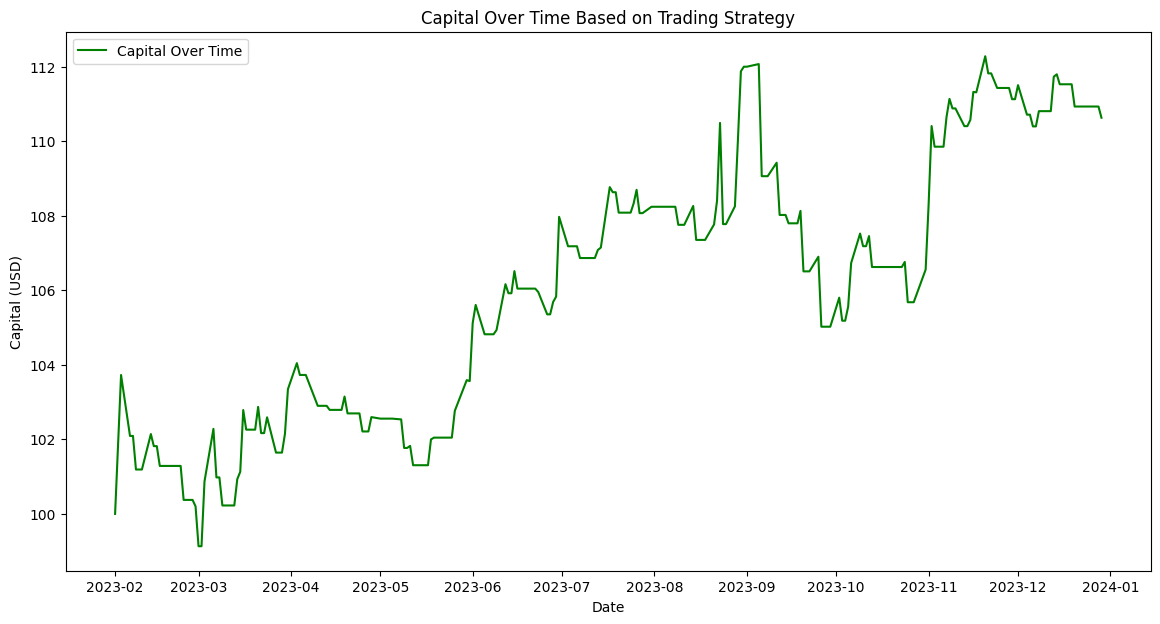

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل
trading_fraction = 0.5

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []
# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        investment_amount = capital * trading_fraction
        shares_bought = investment_amount / results_df.loc[i, 'y_actual']
        shares += shares_bought
        capital -= investment_amount
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        shares_sold = shares
        capital += shares_sold * results_df.loc[i, 'y_actual']
        shares -= shares_sold
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['buy_fraction_sell_all_capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'buy_fraction_sell_all_capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['buy_fraction_sell_all_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


Total Profit: 16.00 USD
            ds    y_actual  y_predicted signal  buy_sell_fraction_capital
1   2023-02-01  145.429993   143.735489    Buy                 100.000000
2   2023-02-02  150.820007   145.565598    Buy                 101.853130
3   2023-02-03  154.500000   149.615036    Buy                 103.728339
4   2023-02-06  151.729996   154.580261   Sell                 102.092721
5   2023-02-07  154.649994   152.024307    Buy                 102.954814
..         ...         ...          ...    ...                        ...
226 2023-12-22  193.600006   194.531876   Sell                 116.342022
227 2023-12-26  193.050003   193.129715   Sell                 116.316973
228 2023-12-27  193.149994   192.976929   Sell                 116.319250
229 2023-12-28  193.580002   192.819061    Buy                 116.324146
230 2023-12-29  192.529999   193.203537   Sell                 116.002689

[230 rows x 5 columns]


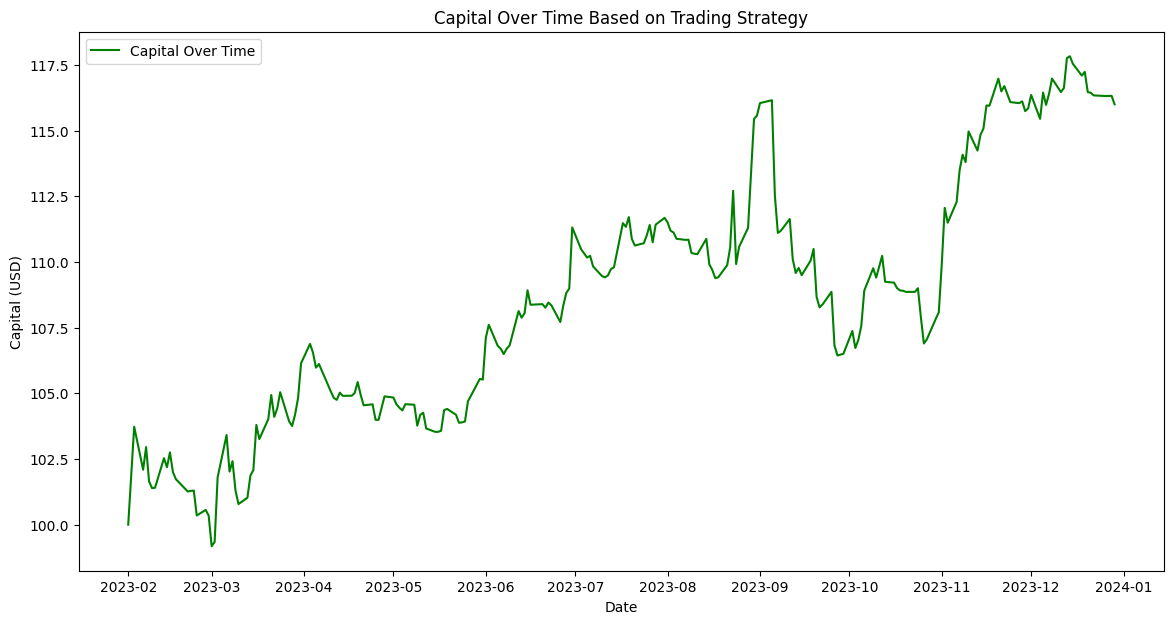

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل
trading_fraction = 0.5

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []
# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        investment_amount = capital * trading_fraction
        shares_bought = investment_amount / results_df.loc[i, 'y_actual']
        shares += shares_bought
        capital -= investment_amount
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        shares_sold = shares * trading_fraction
        capital += shares_sold * results_df.loc[i, 'y_actual']
        shares -= shares_sold
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['buy_sell_fraction_capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'buy_sell_fraction_capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['buy_sell_fraction_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


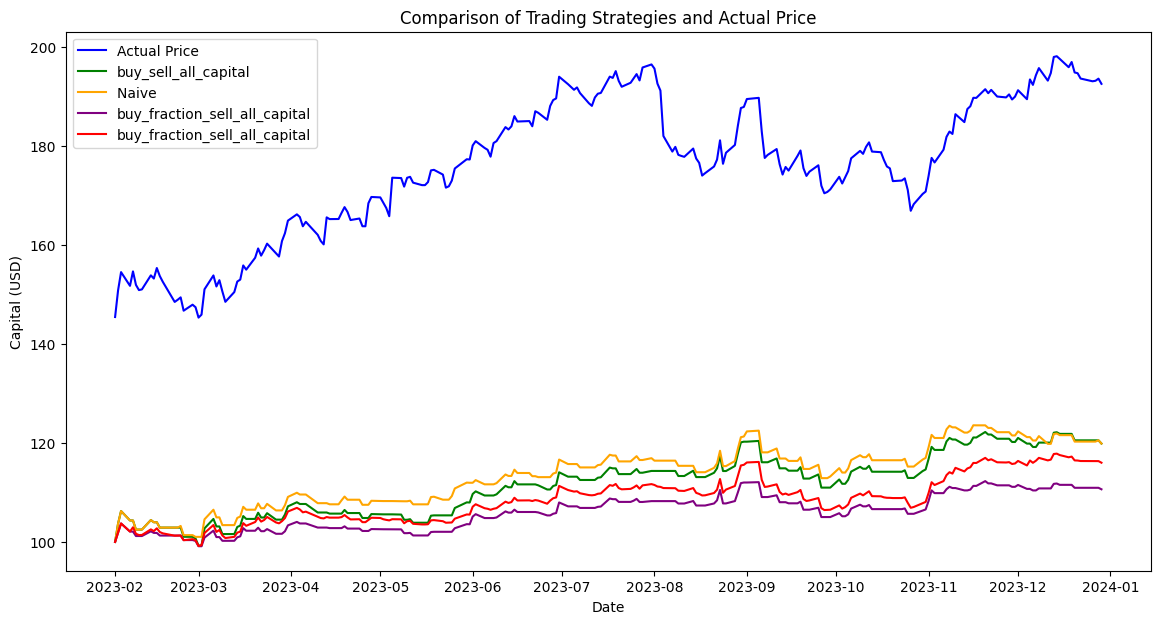

In [120]:
plt.figure(figsize=(14, 7))


plt.plot(results_df['ds'], results_df['y_actual'], label='Actual Price', color='blue')


plt.plot(results_df['ds'], results_df['buy_sell_all_capital'], label='buy_sell_all_capital', color='green')


plt.plot(results_df['ds'], results_df['naive_capital'], label='Naive ', color='orange')


plt.plot(results_df['ds'],results_df['buy_fraction_sell_all_capital'] , label='buy_fraction_sell_all_capital', color='purple')

plt.plot(results_df['ds'],results_df['buy_sell_fraction_capital'] , label='buy_fraction_sell_all_capital', color='red')

plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Comparison of Trading Strategies and Actual Price')
plt.legend()
plt.show()

In [121]:
results_df_predict=pd.read_csv('/content/one_month_input_one_dY.csv',)
results_df_predict

,ds,y_actual,y_predicted
0,2023-01-31,144.289993,140.42755
1,2023-02-01,145.429993,143.24666
2,2023-02-02,150.820007,145.26890
3,2023-02-03,154.500000,149.06754
4,2023-02-06,151.729996,153.91434
...,...,...,...
226,2023-12-22,193.600006,193.98984
227,2023-12-26,193.050003,193.25229
228,2023-12-27,193.149994,192.46585
229,2023-12-28,193.580002,192.46298


In [122]:
results_df

,ds,y_actual,y_predicted,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,y_naive,signal,buy_sell_all_capital,naive_capital,buy_fraction_sell_all_capital,buy_sell_fraction_capital
1,2023-02-01,145.429993,143.735489,138.038666,140.502045,141.913528,142.765167,143.735489,144.062759,144.759430,145.578537,147.175552,144.289993,Buy,100.000000,100.000000,100.000000,100.000000
2,2023-02-02,150.820007,145.565598,141.945480,143.604324,144.452957,144.995010,145.565598,145.937988,146.541962,147.169083,148.494370,145.429993,Buy,103.706261,103.706261,101.853130,101.853130
3,2023-02-03,154.500000,149.615036,145.330093,147.154266,148.373993,148.963516,149.615036,150.044922,150.771378,151.460968,152.917404,150.820007,Buy,106.236683,106.236683,103.728339,103.728339
4,2023-02-06,151.729996,154.580261,148.956085,151.569656,153.221115,153.951492,154.580261,154.924561,155.800079,156.744003,158.272141,154.500000,Sell,104.331983,104.331983,102.092721,102.092721
5,2023-02-07,154.649994,152.024307,147.121735,149.364548,150.790573,151.278183,152.024307,152.225052,153.027847,153.673477,155.078934,151.729996,Buy,104.331983,104.331983,102.092721,102.954814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,2023-12-22,193.600006,194.531876,192.302353,193.064285,193.650299,194.084869,194.531876,194.853592,195.243088,195.786362,196.659393,194.679993,Sell,120.519550,120.265331,110.933777,116.342022
227,2023-12-26,193.050003,193.129715,190.960663,191.694519,192.243835,192.645767,193.129715,193.469040,193.905777,194.445282,195.344574,193.600006,Sell,120.519550,120.265331,110.933777,116.316973
228,2023-12-27,193.149994,192.976929,191.038620,191.716721,192.205276,192.572586,192.976929,193.284805,193.630600,194.069809,194.862961,193.050003,Sell,120.519550,120.265331,110.933777,116.319250
229,2023-12-28,193.580002,192.819061,191.096954,191.671570,192.132721,192.470490,192.819061,193.053040,193.337265,193.746857,194.469559,193.149994,Buy,120.519550,120.533076,110.933777,116.324146


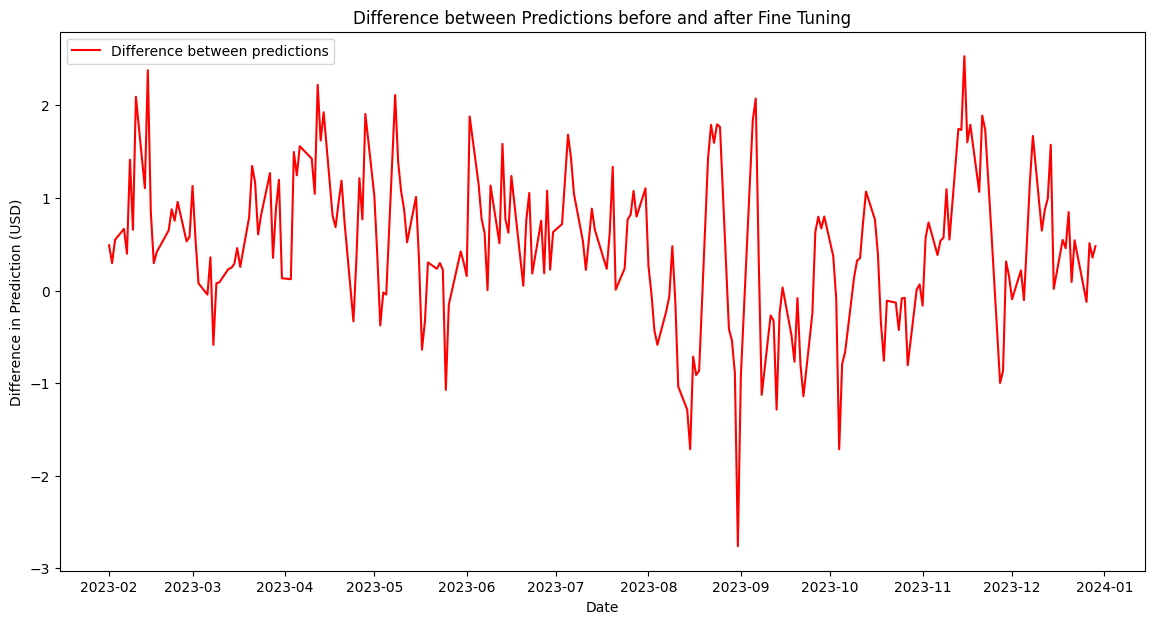

In [123]:
plt.figure(figsize=(14, 7))

# محاسبه تفاوت بین دو پیش‌بینی
results_df['difference'] = results_df['y_predicted'] - results_df_predict['y_predicted']

plt.plot(results_df['ds'], results_df['difference'], label='Difference between predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Difference in Prediction (USD)')
plt.title('Difference between Predictions before and after Fine Tuning')
plt.legend()
plt.show()


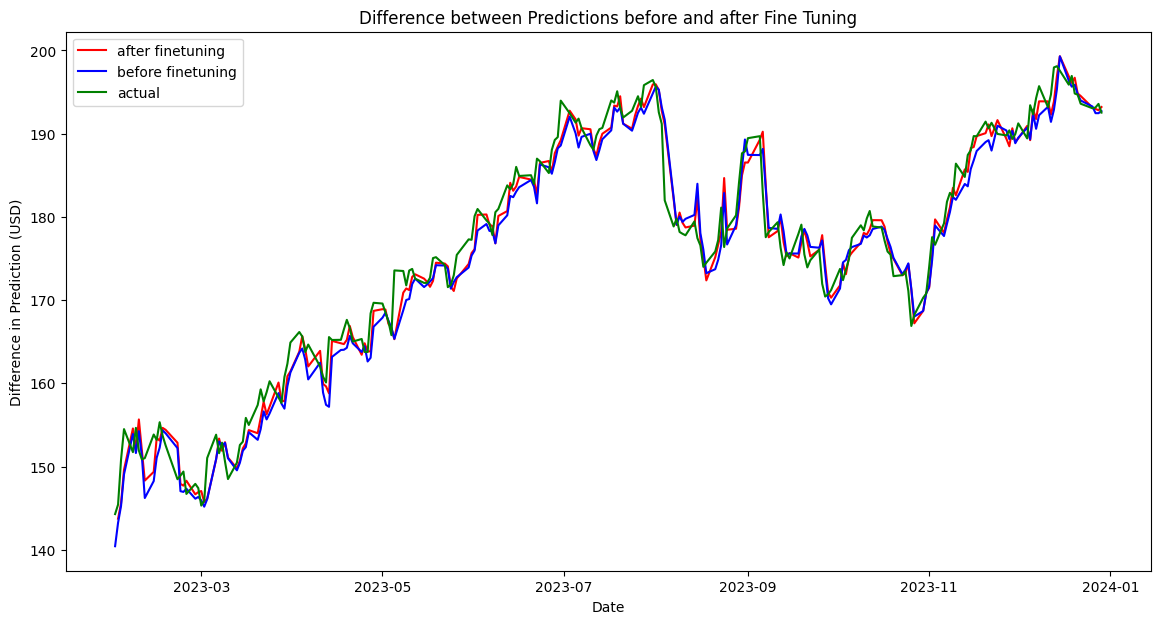

In [133]:
results_df['ds'] = pd.to_datetime(results_df['ds'])
results_df_predict['ds'] = pd.to_datetime(results_df_predict['ds'])

# رسم نمودار
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['y_predicted'], label='after finetuning', color='red')
plt.plot(results_df_predict['ds'], results_df_predict['y_predicted'], label='before finetuning', color='blue')
plt.plot(results_df_predict['ds'], results_df_predict['y_actual'], label='actual', color='green')

plt.xlabel('Date')
plt.ylabel('Difference in Prediction (USD)')
plt.title('Difference between Predictions before and after Fine Tuning')
plt.legend()
plt.show()

In [136]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# فرض کنید نتایج پیش‌بینی‌ها در دو DataFrame به نام‌های results_df و results_df_predict موجود هستند.

# تبدیل ستون‌های 'ds' به فرمت datetime
results_df['ds'] = pd.to_datetime(results_df['ds'])
results_df_predict['ds'] = pd.to_datetime(results_df_predict['ds'])

# محاسبه MSE برای هر DataFrame
mse_results_df = mean_squared_error(results_df['y_actual'], results_df['y_predicted'])
mse_results_df_predict = mean_squared_error(results_df_predict['y_actual'], results_df_predict['y_predicted'])


# نمایش تفاوت بین MSE‌ها
print(f"MSE for results_df: {mse_results_df}")
print(f"MSE for results_df_predict: {mse_results_df_predict}")



MSE for results_df: 5.663574718473398
MSE for results_df_predict: 7.127781104585507


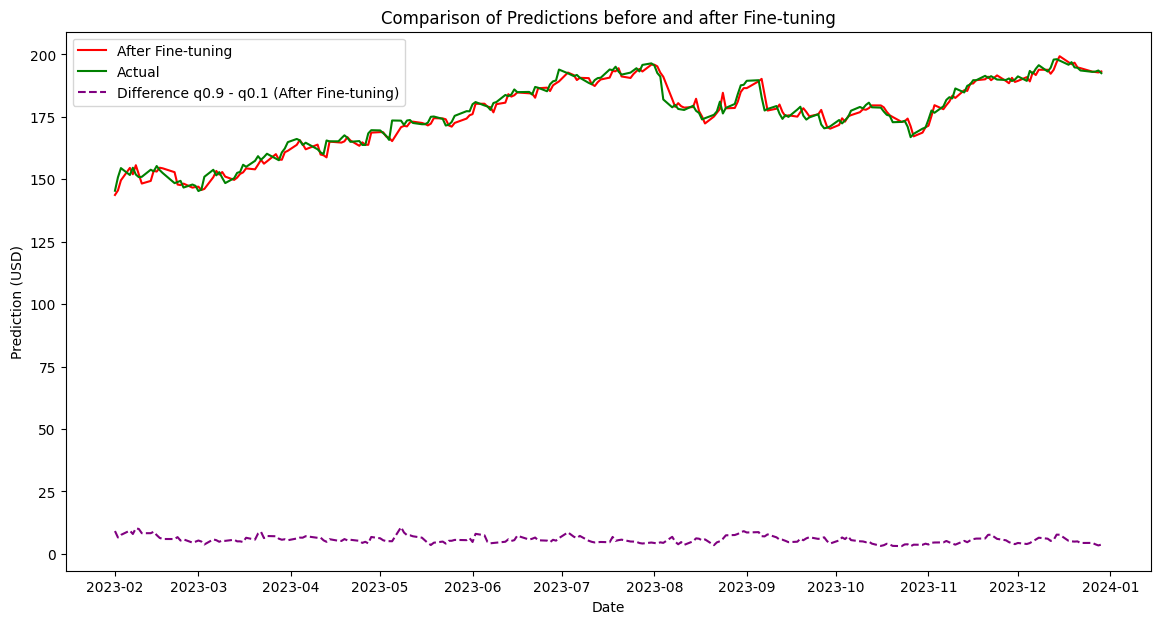

In [147]:

results_df['timesfm_diff_q'] = results_df['timesfm-q-0.9'] - results_df['timesfm-q-0.1']

# رسم نمودار مقایسه‌ای
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['y_predicted'], label='After Fine-tuning', color='red')

plt.plot(results_df['ds'], results_df['y_actual'], label='Actual', color='green')

# اضافه کردن تفاوت timesfm-q-0.1 و timesfm-q-0.9 فقط برای results_df
plt.plot(results_df['ds'], results_df['timesfm_diff_q'], label='Difference q0.9 - q0.1 (After Fine-tuning)', color='purple', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Prediction (USD)')
plt.title('Comparison of Predictions before and after Fine-tuning')
plt.legend()
plt.show()




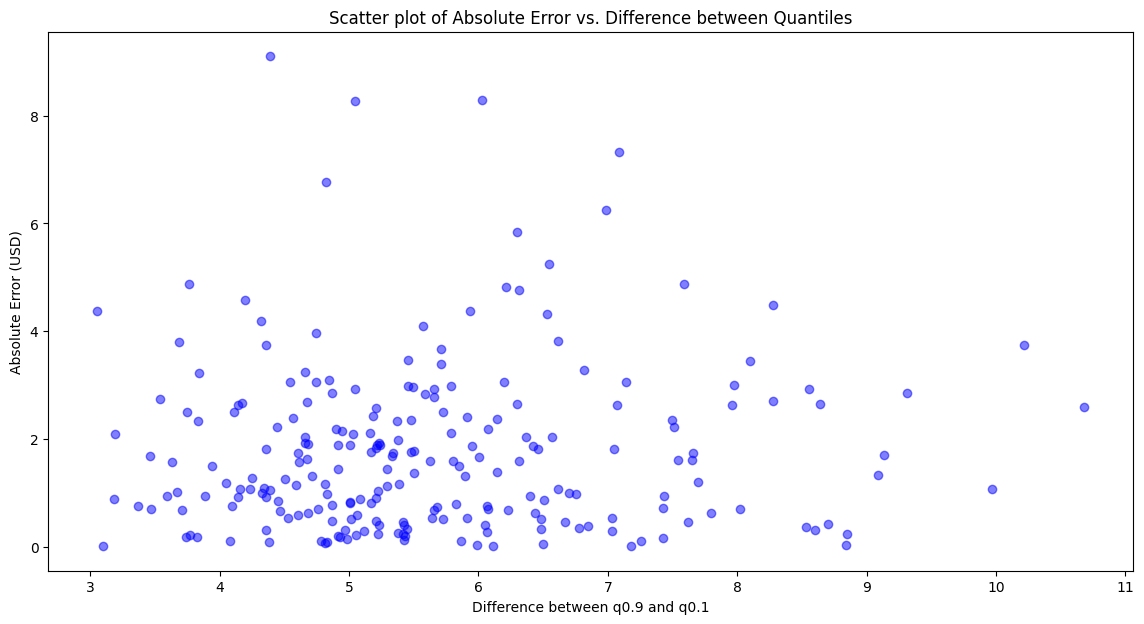

In [143]:


# محاسبه تفاوت بین timesfm-q-0.1 و timesfm-q-0.9 برای results_df
results_df['timesfm_diff_q'] = results_df['timesfm-q-0.9'] - results_df['timesfm-q-0.1']

# محاسبه خطای مطلق برای results_df
results_df['absolute_error'] = abs(results_df['y_actual'] - results_df['y_predicted'])



# رسم نمودار پراکندگی برای نمایش رابطه بین تفاوت کوانتایل‌ها و خطای مطلق
plt.figure(figsize=(14, 7))
plt.scatter(results_df['timesfm_diff_q'], results_df['absolute_error'], color='blue', alpha=0.5)
plt.xlabel('Difference between q0.9 and q0.1')
plt.ylabel('Absolute Error (USD)')
plt.title('Scatter plot of Absolute Error vs. Difference between Quantiles')
plt.show()


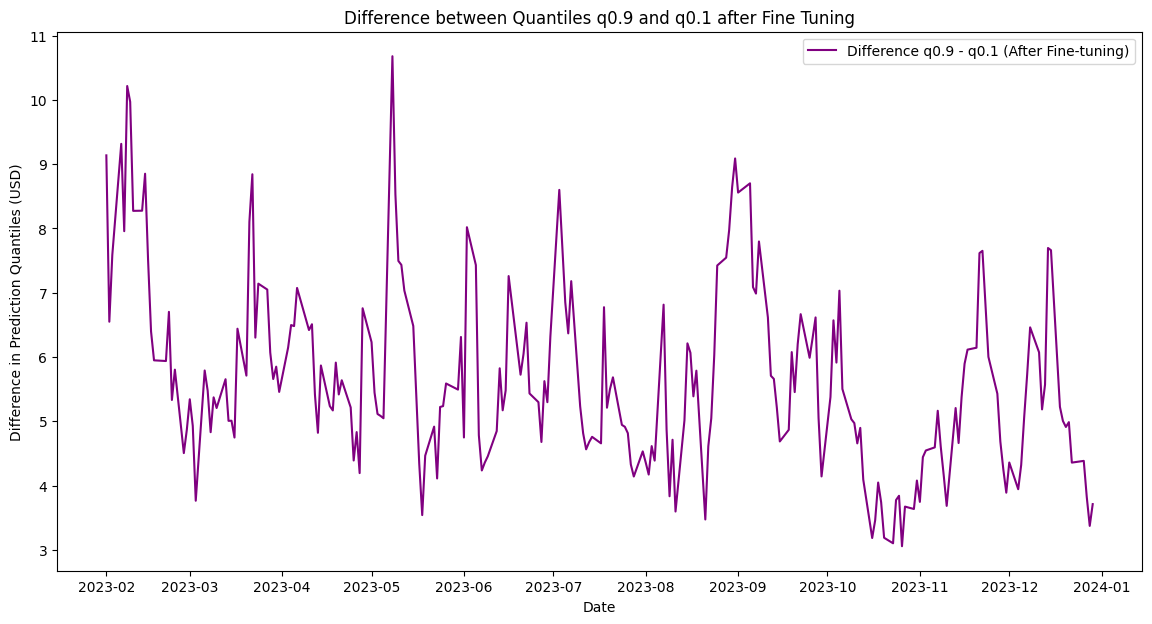

In [146]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['timesfm_diff_q'], label='Difference q0.9 - q0.1 (After Fine-tuning)', color='purple')

plt.xlabel('Date')
plt.ylabel('Difference in Prediction Quantiles (USD)')
plt.title('Difference between Quantiles q0.9 and q0.1 after Fine Tuning')
plt.legend()
plt.show()


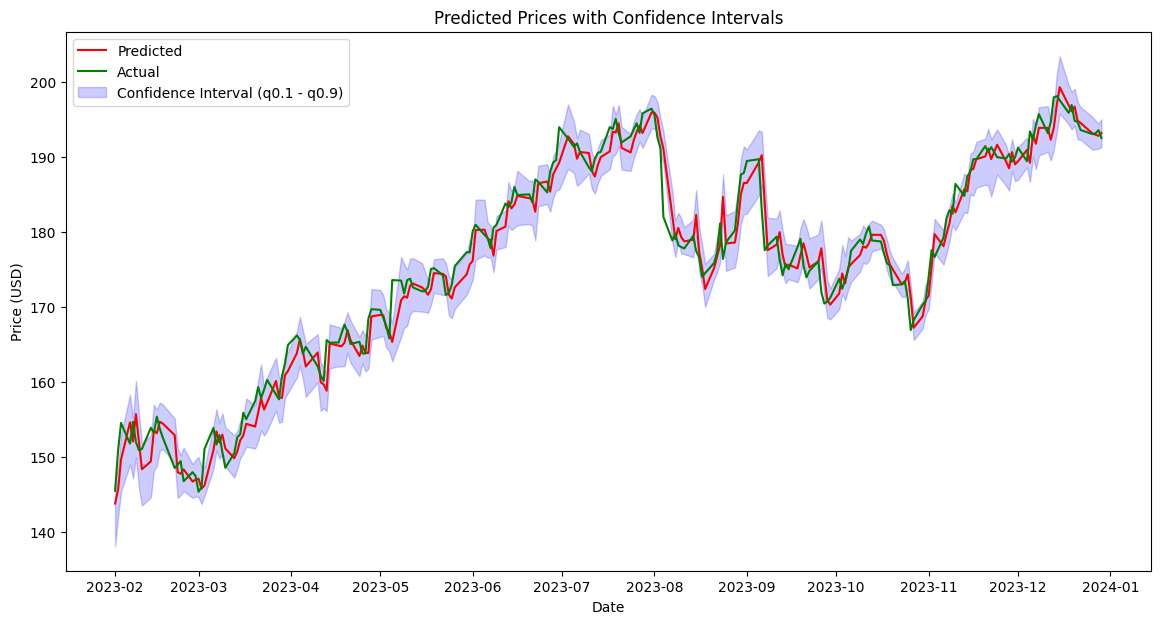

In [148]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['y_predicted'], label='Predicted', color='red')
plt.plot(results_df['ds'], results_df['y_actual'], label='Actual', color='green')
plt.fill_between(results_df['ds'], results_df['timesfm-q-0.1'], results_df['timesfm-q-0.9'], color='blue', alpha=0.2, label='Confidence Interval (q0.1 - q0.9)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Predicted Prices with Confidence Intervals')
plt.legend()
plt.show()
